This quickstart notebook allows to test and mess around with the MLPF GNN model in a standalone way. For actual training, we don't use a notebook; please refer to `README.md`.


Run the notebook from `notebooks/atlas-tf-mlpf-quickstart.ipynb`.

Model takes about 2 minutes in CODE.

In [1]:
# if import fails, you will have to !pip install <missingmodule>
import bz2, pickle
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt
#!pip install h5py

2023-06-15 01:55:51.130472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 01:55:51.847431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path += ["../mlpf"]

In [3]:
import tfmodel

In [4]:
# use wget if curl is not installed
# !wget --no-check-certificate -nc https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2
# !curl https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2 --output ./tev14_pythia8_ttbar_0_0.pkl.bz2

In [5]:
data = pickle.load(bz2.BZ2File("tev14_pythia8_ttbar_0_0.pkl.bz2", "r"))

In [6]:
print(data.keys())

dict_keys(['X', 'ycand', 'ygen'])


In [7]:
YT = 'ycand'
# 100 events in one file
print("Events:",len(data["X"]),"\n True evts:", len(data[YT]))
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# lots of particles in one event
ic = ["1","et","eta","sinp","cosp",'E','Eem','Ehad']
sic=("   "+"  {:<5}"*len(ic)+"\n").format(*tuple(ic))
it = ["2","pt","eta","sinp","cosp",'P', 'etao',"sinpo", 'cospo', 'Q']
sit=("   "+"  {:<5}"*len(ic)+"\n").format(*tuple(it))

print(data["X"][0].shape,"\nFirst 5 reco-objects data:\n",sic,sit,data["X"][0][:5][0:9],
      "\n\n",data[YT][0].shape,"\nFirst 5 target-particles:\n",data[YT][0][:5]
      "\n\n",data['ygen'][0].shape,"\nFirst 5 target-particles:\n",data[YT][0][:5])



Events: 100 
 True evts: 100
(5139, 12) 
First 5 reco-objects data:
      1      et     eta    sinp   cosp   E      Eem    Ehad 
      2      pt     eta    sinp   cosp   P      etao   sinpo
 [[ 2.000  0.408 -1.268 -0.493  0.870  0.782 -2.139  0.996 -0.092 -1.000
   0.000  0.000]
 [ 2.000  0.569 -0.574 -0.853 -0.522  0.665 -1.759  0.515 -0.857  1.000
   0.000  0.000]
 [ 2.000  0.855  1.407  0.189 -0.982  1.850  1.457  0.742 -0.670  1.000
   0.000  0.000]
 [ 2.000  0.744  2.334 -0.827  0.562  3.875  2.369 -0.980  0.199  1.000
   0.000  0.000]
 [ 2.000  1.019  1.147  0.401  0.916  1.767  1.264  0.866  0.500 -1.000
   0.000  0.000]] 

 (5139, 7) 
First 5 target-particles:
 [[ 1.000 -1.000  0.432 -1.268 -0.493  0.870  0.000]
 [ 1.000  1.000  0.564 -0.574 -0.853 -0.522  0.000]
 [ 1.000  1.000  0.832  1.407  0.189 -0.982  0.000]
 [ 1.000  1.000  0.769  2.334 -0.827  0.562  0.000]
 [ 1.000 -1.000  1.012  1.147  0.401  0.916  0.000]]


In [8]:
#Pad the number of elements to a size that's divisible by the bin size
Xs = []
ys = []

max_size = 50*128
for i in range(len(data["X"])):
    X = data["X"][i][:max_size, :]
    y = data[YT][i][:max_size, :]
    Xpad = np.pad(X, [(0, max_size - X.shape[0]), (0, 0)])
    ypad = np.pad(y, [(0, max_size - y.shape[0]), (0, 0)])
    Xpad = Xpad.astype(np.float32)
    ypad = ypad.astype(np.float32)
    Xs.append(Xpad)
    ys.append(ypad)
    
X = np.stack(Xs)
y = np.stack(ys)

In [9]:
# count classes in data
input_classes = np.unique(X[:, :, 0].flatten())
output_classes = np.unique(y[:, :, 0].flatten())
num_output_classes = len(output_classes)

In [10]:
def transform_target(y):
    return {
        "cls": tf.one_hot(tf.cast(y[:, :, 0], tf.int32), num_output_classes),
        "charge": y[:, :, 1:2],
        "pt" : y[:, :, 2:3],
        "eta": y[:, :, 3:4],
        "sin_phi": y[:, :, 4:5],
        "cos_phi": y[:, :, 5:6],
        "energy": y[:, :, 6:7],
    }
yt = transform_target(y)

def transform_output(i,yvals,pmask_i):
    return {"px": 100.* yvals["pt"][i][pmask_i]*yvals["cos_phi"][i][pmask_i],
          "py": 100.* yvals["pt"][i][pmask_i]*yvals["sin_phi"][i][pmask_i],
          "pz": 100.* yvals["pt"][i][pmask_i]*np.sinh(yvals["eta"][i][pmask_i]),
          "E": 100.* yvals["pt"][i][pmask_i]*np.cosh(yvals["eta"][i][pmask_i])}


2023-06-15 01:56:10.961991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3032 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:81:00.0, compute capability: 8.0


In [11]:
from tfmodel.model import PFNetDense

In [12]:
msk_true_particle = y[:, :, 0]!=0

In [13]:
#check out composition of true sample
np.unique(y[msk_true_particle][:, 0], return_counts=True)

(array([ 1.000,  2.000,  3.000,  4.000,  5.000], dtype=float32),
 array([237979, 103181, 144119,    647,    278]))

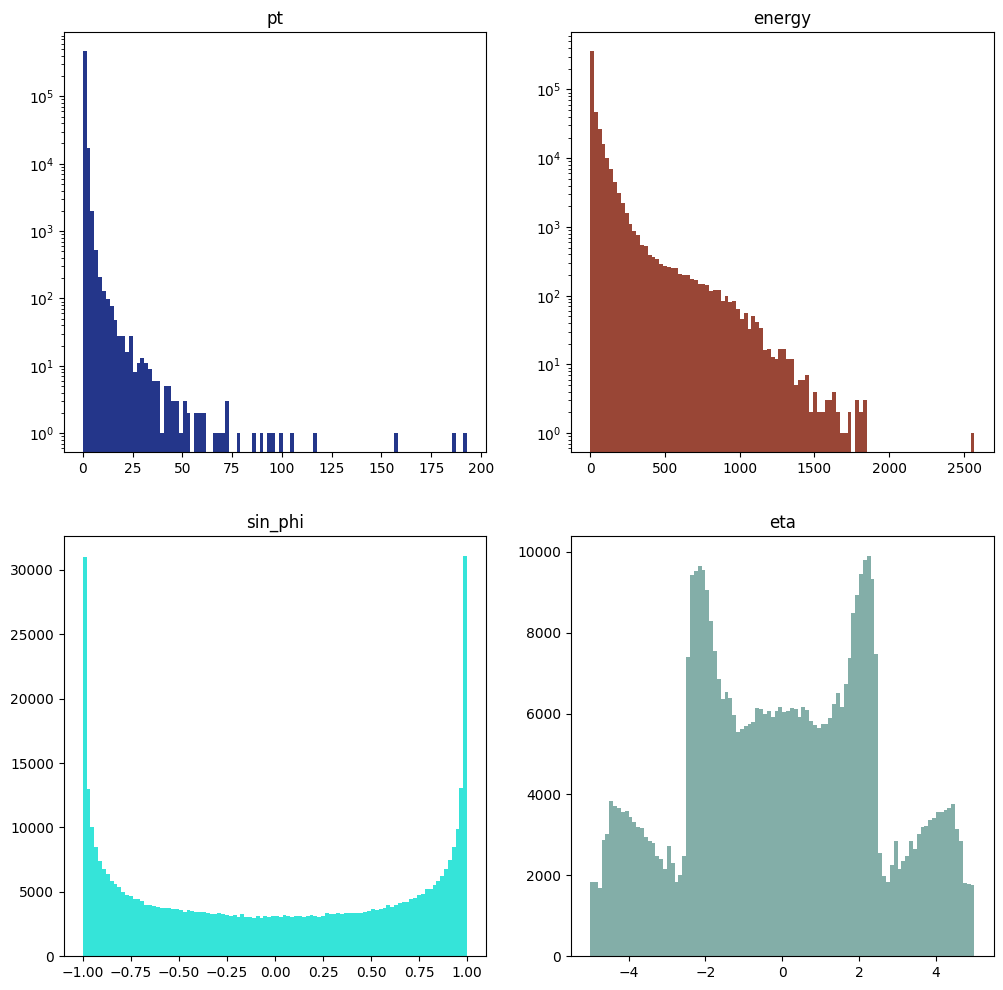

In [14]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2, ncols=2, 
                                    figsize=(12, 12))
axes = (ax0,ax1,ax2,ax3)
varz = ("pt","energy","sin_phi","eta")

#new colors each time, for fun and profit
from random import uniform
for a,v in zip(axes,varz):
    a.hist(yt[v][msk_true_particle].flatten(), bins=100,color=(uniform(0, 1), uniform(0, 1), uniform(0, 1)));
    a.set_title(v)
    if v in ("pt","energy") : a.set_yscale("log")

In [15]:
from benedict import benedict
d = benedict("../parameters/delphes.yaml", format="yaml")
#dir(benedict.BeneDict)
#d = benedict.load_yaml_file("../parameters/delphes.yaml")
#d["parameters"]["combined_graph_layer"]

In [16]:
model = PFNetDense(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    activation="elu", #tf.nn.elu,
    hidden_dim=128,
    bin_size=128,
    input_encoding="default",
    multi_output=True, #guess
    combined_graph_layer = d["parameters"]["combined_graph_layer"],
)

# #temporal weight mode means each input element in the event can get a separate weight
model.compile(
    loss={
        "cls": tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        "charge": tf.keras.losses.MeanSquaredError(),
        "pt": tf.keras.losses.MeanSquaredError(),
        "energy": tf.keras.losses.MeanSquaredError(),
        "eta": tf.keras.losses.MeanSquaredError(),
        "sin_phi": tf.keras.losses.MeanSquaredError(),
        "cos_phi": tf.keras.losses.MeanSquaredError()
    },
    optimizer="adam",
    sample_weight_mode="temporal"
)

In [17]:
model(X[:1]) #need to call the model before you can see it
model.summary() 
model.load_weights('my_model_weights.h5')

2023-06-15 01:57:20.892561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoding (InputEncodi  multiple                 0         
 ng)                                                             
                                                                 
 cg_0 (CombinedGraphLayer)   multiple                  35840     
                                                                 
 cg_energy_0 (CombinedGraphL  multiple                 35840     
 ayer)                                                           
                                                                 
 output_decoding (OutputDeco  multiple                 496997    
 ding)                                                           
                                                                 
Total params: 568,677
Trainable params: 555,877
Non-trainable params: 12,800
___________________________________________

In [18]:
def plot_loss(history):
  '''Plot the training history'''
  plt.figure()
  plt.plot(history.history['loss'], label='loss')
  for i in ("cls","charge","pt","energy","eta","sin_phi","cos_phi") : plt.plot(history.history[i+"_loss"],
                                                                               label=i)
  plt.ylim([0.01, 8])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.yscale("log")
  plt.legend()
  plt.grid(True)

#once per epoch
cp_path = "training/cp-{epoch:02d}.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path, 
                                                # monitor='loss', 
                                                verbose=False, 
                                                # save_best_only=True,
                                                save_weights_only=True,
                                                # initial_value_threshold=10
                                               )

history = model.fit(X, yt, verbose=1,
                   epochs=50, batch_size=5)

Epoch 1/50


2023-06-15 01:57:59.497201: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe744021840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-15 01:57:59.497285: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2023-06-15 01:57:59.504429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-15 01:57:59.626036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-06-15 01:57:59.682681: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-15 01:57:59.742452: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - 16s 178ms/step - loss: 2379.8003 - charge_loss: 1.9034 - cls_loss: 0.5461 - cos_phi_loss: 0.9587 - energy_loss: 1966.6616 - eta_loss: 4.6541 - pt_loss: 403.7006 - sin_phi_loss: 1.3762
Epoch 2/50
20/20 [==============================] - 4s 176ms/step - loss: 922.2914 - charge_loss: 0.1850 - cls_loss: 0.5288 - cos_phi_loss: 0.2051 - energy_loss: 366.2346 - eta_loss: 0.7984 - pt_loss: 554.0879 - sin_phi_loss: 0.2518
Epoch 3/50
20/20 [==============================] - 4s 177ms/step - loss: 554.7304 - charge_loss: 0.0343 - cls_loss: 0.5215 - cos_phi_loss: 0.1597 - energy_loss: 296.9112 - eta_loss: 0.1961 - pt_loss: 256.7184 - sin_phi_loss: 0.1893
Epoch 4/50
20/20 [==============================] - 4s 177ms/step - loss: 580.8989 - charge_loss: 0.0324 - cls_loss: 0.5172 - cos_phi_loss: 0.1400 - energy_loss: 294.2862 - eta_loss: 0.1598 - pt_loss: 285.6044 - sin_phi_loss: 0.1590
Epoch 5/50
20/20 [==============================] - 4s 176ms/step - loss: 51

2023-06-15 02:01:44.480837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cg_0_ffn_dist_dense_0_input' with dtype float and shape [?,6400,14]
	 [[{{node cg_0_ffn_dist_dense_0_input}}]]
2023-06-15 02:01:44.502153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cg_0_ffn_dist_dense_0_input' with dtype float and shape [?,6400,14]
	 [[{{node cg_0_ffn_dist_dense_0_input}}]]
2023-06-15 02:01:44.509211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placehold

INFO:tensorflow:Assets written to: latest_model/assets


INFO:tensorflow:Assets written to: latest_model/assets


20/20 [==============================] - 2s 67ms/step


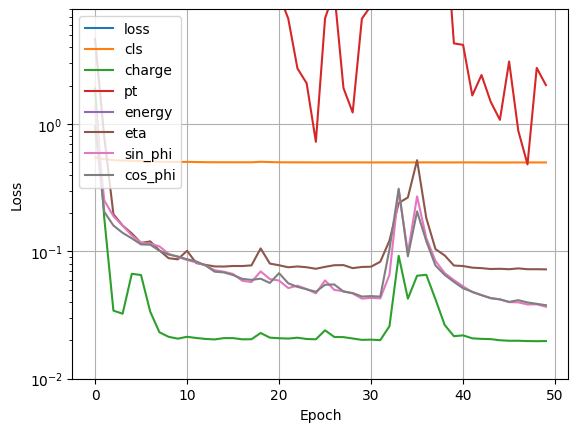

In [19]:
plot_loss(history)
model.save("latest_model")
ypred = model.predict(X, batch_size=5)

In [20]:
#index of the class prediction output values
pred_id_offset = len(output_classes)
ypred_ids_raw = ypred["cls"]

In [21]:
headers = ["","null","h^\pm","h^0","\gamma","e",'\mu']
tdata = sklearn.metrics.confusion_matrix(np.argmax(ypred_ids_raw, axis=-1).flatten(),
                                         np.argmax(yt["cls"], axis=-1).flatten(), labels=output_classes)


In [22]:
#!pip install tabulate
import tabulate
print(tabulate.tabulate(tdata,headers=headers,showindex=["no reco","cH","nH","gamma","e","mu"],tablefmt="orgtbl"))

|         |   null |   h^\pm |   h^0 |   \gamma |   e |   \mu |
|---------+--------+---------+-------+----------+-----+-------|
| no reco | 151571 |       0 |  5843 |     1179 |   0 |     0 |
| cH      |      0 |  237979 | 13594 |        0 |   3 |     0 |
| nH      |   1923 |       0 | 81705 |     1309 |   0 |     0 |
| gamma   |    302 |       0 |  2039 |   141615 |   0 |     0 |
| e       |      0 |       0 |     0 |       16 | 641 |     0 |
| mu      |      0 |       0 |     0 |        0 |   3 |   278 |


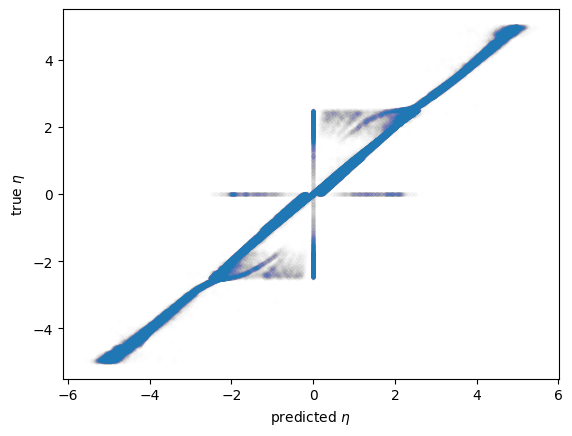

In [23]:
msk_particles = (X[:, :, 0]!=0)
plt.scatter(
    ypred["eta"][msk_particles].flatten(),
    yt["eta"][msk_particles].flatten(),marker='.', alpha=0.005)
plt.xlabel("predicted $\eta$")
plt.ylabel("true $\eta$");

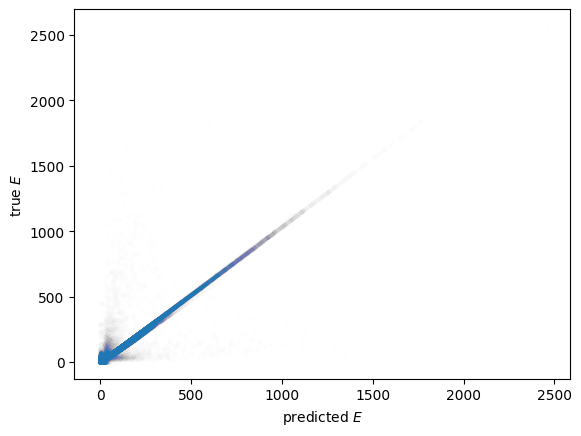

In [24]:
plt.scatter(
    ypred["energy"][msk_particles].flatten(),
    yt["energy"][msk_particles].flatten(), marker=".", alpha=0.005)
plt.xlabel("predicted $E$")
plt.ylabel("true $E$");

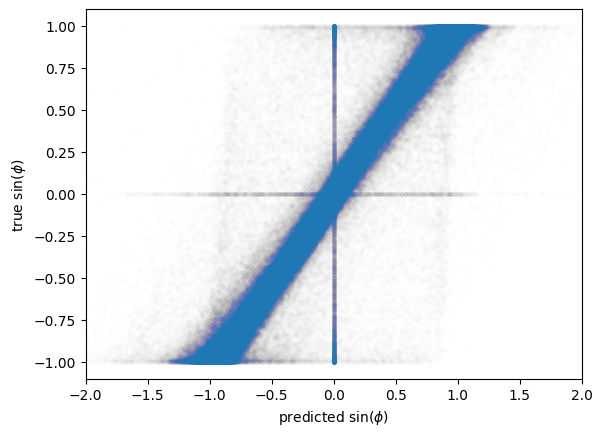

In [25]:
plt.scatter(
    ypred["sin_phi"][msk_particles].flatten(),
    yt["sin_phi"][msk_particles].flatten(), marker=".", alpha=0.005)
plt.xlim(-2,  2)
plt.xlabel("predicted $\sin(\phi)$")
plt.ylabel("true $\sin(\phi)$");

## toward a jet-reconstruction based loss term
- Reconstruct jets with fastjets
- Compare 

In [26]:
# fastjet reconstructs jets
import fastjet
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)

In [ ]:
# prepare jet imports as awk array of the first event, (pred/true)
import awkward as ak
import vector
awk_pred = vector.zip(transform_output(0,ypred,msk_particles[0]))
awk_true = vector.zip(transform_output(0,yt,msk_particles[0]))

print("pred jet inputs:",awk_pred,"\nrule jet inputs:",awk_true,
     "\nEqual arrays?",ak.almost_equal(awk_pred,awk_true))
#print(notpad.shape)
#ypred["pt"][notpad].shape
#ak.Array({'x':[1,2,3],'y':[4,5,6]})


In [ ]:
import vector

In [64]:
# some awkward help getting leading jets 
def get_leading_jets(cs):
    # (more than 20 jets probably not useful in trigger)
    pt2 = lambda v : np.square(v["px"])+np.square(v["py"])
    indices = np.argsort(pt2(j))
    return j[indices[-20:]]

c_p = fastjet.ClusterSequence(awk_pred, jetdef)
ljp = get_leading_jets(c_p.inclusive_jets())
c_t = fastjet.ClusterSequence(awk_true, jetdef)
ljt = get_leading_jets(c_t.inclusive_jets())
    

In [65]:
print("pred:",ljp,
      "\nrule:",ljt,
      "\nEqual?:",ak.almost_equal(ljp,ljt))

pred: [{px: 4.32e+03, py: 876, pz: -3.3e+03, E: 5.6e+03}, ..., {px: 4.99e+03, ...}] 
rule: [{px: 4.32e+03, py: 876, pz: -3.3e+03, E: 5.6e+03}, ..., {px: 4.99e+03, ...}] 
Equal?: True
